# Diabetes Detection and Prediction
## By Amelia Hendricks

# 1. Loading in required libraries

In [37]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Imbalanced data handling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Model and preprocessing imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# Metrics imports
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Model saving and other utilities
import joblib

# SHAP for model interpretation
import shap
import lime
import lime.lime_tabular
import warnings



# 2. Loading in the dataset

In [38]:
# Load your dataset
data = pd.read_csv("/kaggle/input/diabetes-dataset/Dataset of Diabetes .csv")

In [39]:
data.replace(['N ', 'Y '], ['N', 'Y'], inplace=True)
data.replace(['f'], ['F'], inplace=True)

# 3. EDA

In [40]:
data.head(5)

ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N

In [41]:
data.isnull().sum() #looking for missing values

ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64

In [42]:
data.describe()

ID     No_Pation          AGE         Urea           Cr  \
count  1000.000000  1.000000e+03  1000.000000  1000.000000  1000.000000   
mean    340.500000  2.705514e+05    53.528000     5.124743    68.943000   
std     240.397673  3.380758e+06     8.799241     2.935165    59.984747   
min       1.000000  1.230000e+02    20.000000     0.500000     6.000000   
25%     125.750000  2.406375e+04    51.000000     3.700000    48.000000   
50%     300.500000  3.439550e+04    55.000000     4.600000    60.000000   
75%     550.250000  4.538425e+04    59.000000     5.700000    73.000000   
max     800.000000  7.543566e+07    79.000000    38.900000   800.000000   

             HbA1c         Chol           TG          HDL          LDL  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      8.281160     4.862820     2.349610     1.204750     2.609790   
std       2.534003     1.301738     1.401176     0.660414     1.115102   
min       0.900000     0.000000     0.300000     0.200000     0.300000   
25%       6.500000     4.000000     1.500000     0.900000     1.800000   
50%       8.000000     4.800000     2.000000     1.100000     2.500000   
75%      10.200000     5.600000     2.900000     1.300000     3.300000   
max      16.000000    10.300000    13.800000     9.900000     9.900000   

              VLDL          BMI  
count  1000.000000  1000.000000  
mean      1.854700    29.578020  
std       3.663599     4.962388  
min       0.100000    19.000000  
25%       0.700000    26.000000  
50%       0.900000    30.000000  
75%       1.500000    33.000000  
max      35.000000    47.750000

In [43]:
# Loop through each column and count the number of distinct values
for column in data.columns:
    num_distinct_values = len(data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

ID: 800 distinct values
No_Pation: 961 distinct values
Gender: 2 distinct values
AGE: 50 distinct values
Urea: 110 distinct values
Cr: 113 distinct values
HbA1c: 111 distinct values
Chol: 77 distinct values
TG: 69 distinct values
HDL: 48 distinct values
LDL: 65 distinct values
VLDL: 60 distinct values
BMI: 64 distinct values
CLASS: 3 distinct values


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


In [45]:
# Find duplicate IDs
duplicate_ids = data[data.duplicated(subset=['ID'], keep=False)]

# Sort the duplicate rows in ascending order by 'ID'
duplicate_ids_sorted = duplicate_ids.sort_values(by='ID', ascending=True)

# Print the first 25 rows of the sorted duplicates
duplicate_ids_sorted.head(25)


ID  No_Pation Gender  AGE  Urea   Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
846   1      34325      M   56  20.8  800    9.0   4.6  2.0  1.2  2.5   0.9   
273   1      34325      M   58  20.8  800    9.1   6.6  2.9  1.1  4.3   1.3   
847   2      44835      M   60   2.1   56    7.2   6.3  3.7  1.0  3.7   1.7   
541   2      44835      M   60   2.1   56    7.6   3.3  1.7  0.9  1.7   0.8   
848   3      41248      M   53   4.2   55    8.0   5.0  2.5  1.3  2.3   1.6   
301   3      23972      F   56   4.0   45    9.2   4.1  0.6  1.3  1.4   0.9   
849   4      18642      M   55   9.2  101    8.5   5.6  1.9  1.3  1.2   0.7   
108   4      34301      F   43   2.1   55    5.7   4.7  5.3  0.9  1.7   2.4   
487   5      35150      M   63   7.0   84    8.1   6.0  2.2  1.1  4.0   1.0   
850   5      51477      M   58   5.9   67    9.9   5.2  1.8  0.9  3.6   0.6   
339   6      23973      F   61   5.1   72   11.5   4.4  2.1  1.1  2.5   0.9   
851   6      45308      F   58   6.0   66    6.9   5.7  1.3  1.4  4.9   0.6   
174   7      34278      F   46   3.0   59    5.1   5.7  3.8  1.3  2.8   1.7   
63    7      21354      M   44   6.8   64    4.9   4.9  2.8  2.0  1.8   1.2   
640   8      45703      M   51   3.9   53   10.9   3.6  1.1  0.8  2.3   1.0   
852   8      79133      M   55   5.8   60    9.0   4.6  1.9  1.2  2.6   0.8   
274   9      23974      F   60   6.0   72   10.7   4.4  2.1  1.1  2.5   0.9   
64    9      85922      F   35   3.9   38    5.4   3.8  5.9  0.5  4.3   1.0   
181  10      34286      F   45   3.1   54    4.0   5.9  1.8  1.6  3.5   0.8   
65   10     568412      M   40   5.0   63    4.0   4.8  2.5  1.1  2.7   1.1   
853  11     749215      F   42   2.3   52    7.0   5.2  2.8  3.1  1.3   0.9   
641  11      45702      F   54   7.0   72    7.6   4.9  2.8  0.8  3.0   1.2   
145  12        685      M   55   4.8   60    6.0   3.6  3.0  1.5  0.8   1.4   
156  12      23975      M   31   3.0   60   12.3   4.1  2.2  0.7  2.4  15.4   
480  13      34395      F   60   5.4   47    6.8   5.1  2.1  1.1  3.0   1.0   

      BMI CLASS  
846  35.0     Y  
273  33.0     Y  
847  28.0     Y  
541  36.6     Y  
848  30.0     Y  
301  30.0     Y  
849  28.0     Y  
108  25.0     P  
487  28.0     Y  
850  29.0     Y  
339  26.0     Y  
851  24.0     Y  
174  24.0     Y  
63   21.0     N  
640  29.0     Y  
852  30.0     Y  
274  26.0     Y  
64   22.0     N  
181  24.0     Y  
65   23.0     N  
853  24.0     Y  
641  31.0     Y  
145  24.0     P  
156  37.2     Y  
480  28.0     Y

##  **Distribution**

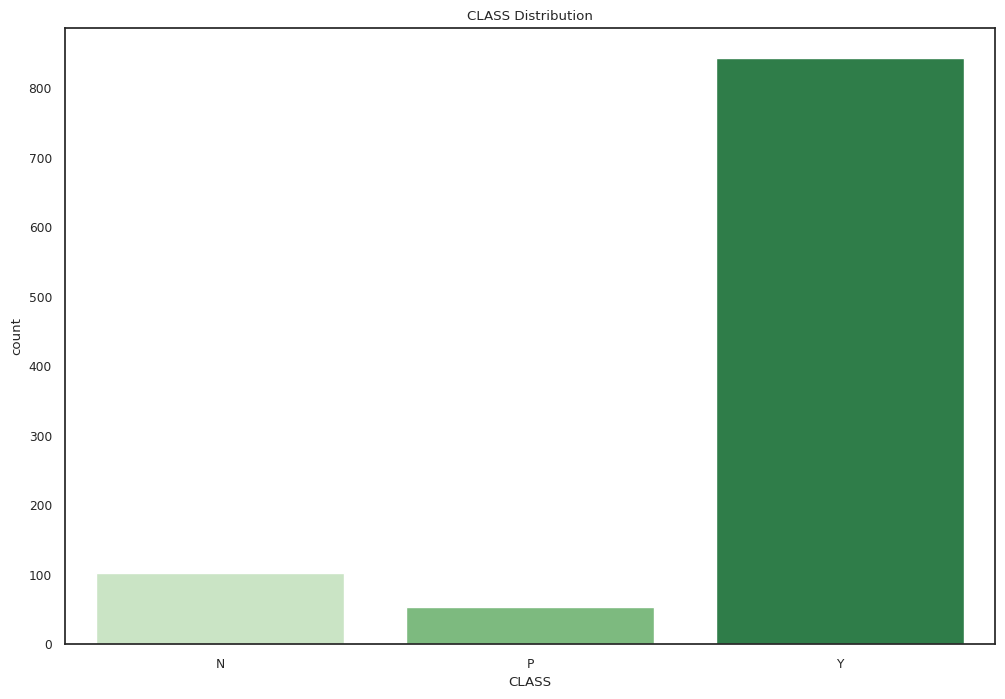

In [46]:
# Count plots for binary variables
for col in ['CLASS']:
    plt.figure(figsize=(12, 8))

    sns.countplot(x=col, data=data, palette='Greens')
    plt.title(f'{col} Distribution')
    plt.show()
    

#### Observations


Labels:

0=Not diabetic

1= Pre-diabetic

2= Diabetic

Note that the dataset is imbalanced.

There is more people in the diabetic class.

The column with prediabetic has the least amount of people.


In [47]:
class_distribution = data['CLASS'].value_counts()
class_distribution

CLASS
Y    844
N    103
P     53
Name: count, dtype: int64

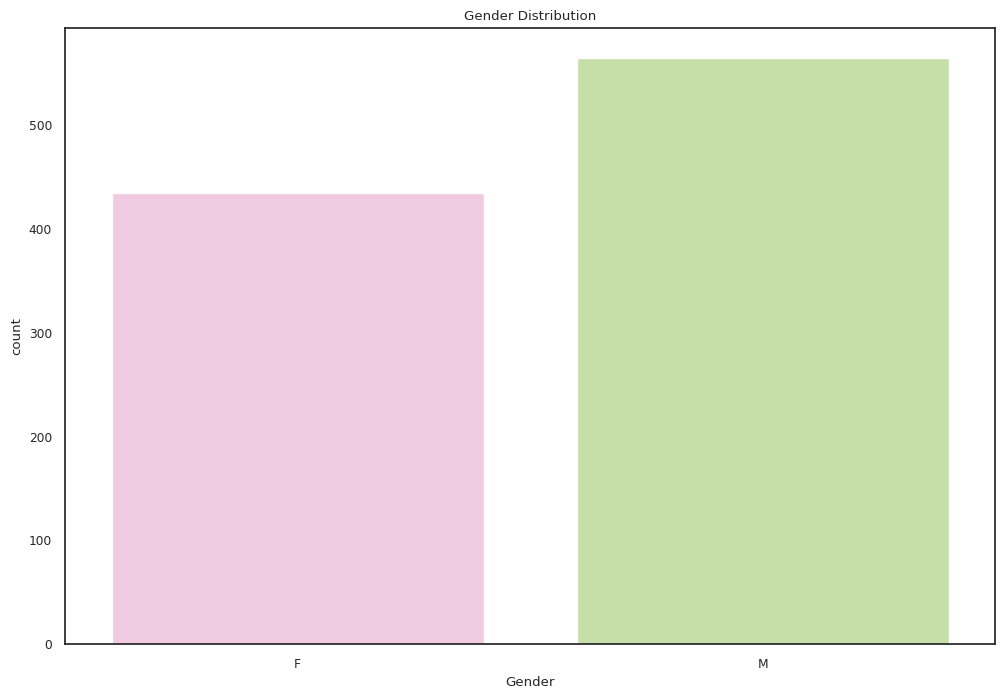

In [48]:
# Count plots for binary variables
for col in ['Gender']:
    plt.figure(figsize=(12, 8))
    sns.countplot(x=col, data=data, palette='PiYG')
    plt.title(f'{col} Distribution')
    plt.show()
    

**Observation**

There are more males than females in the dataset

In [49]:
Gender_distribution = data['Gender'].value_counts()
Gender_distribution

Gender
M    565
F    435
Name: count, dtype: int64

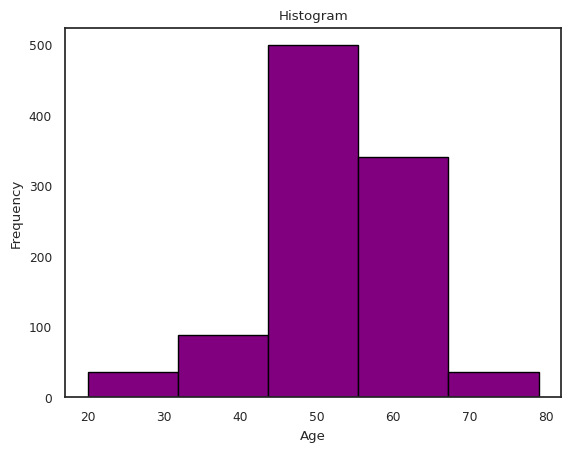

In [50]:
plt.hist(data['AGE'], bins=5, edgecolor='black', color='purple')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

#### Observation

The dataset is made up of people that are between the ages of 21 and 79.

The dataset is mainly made up of people that are 45-55 years of age.

## **Statistical Analysis** 

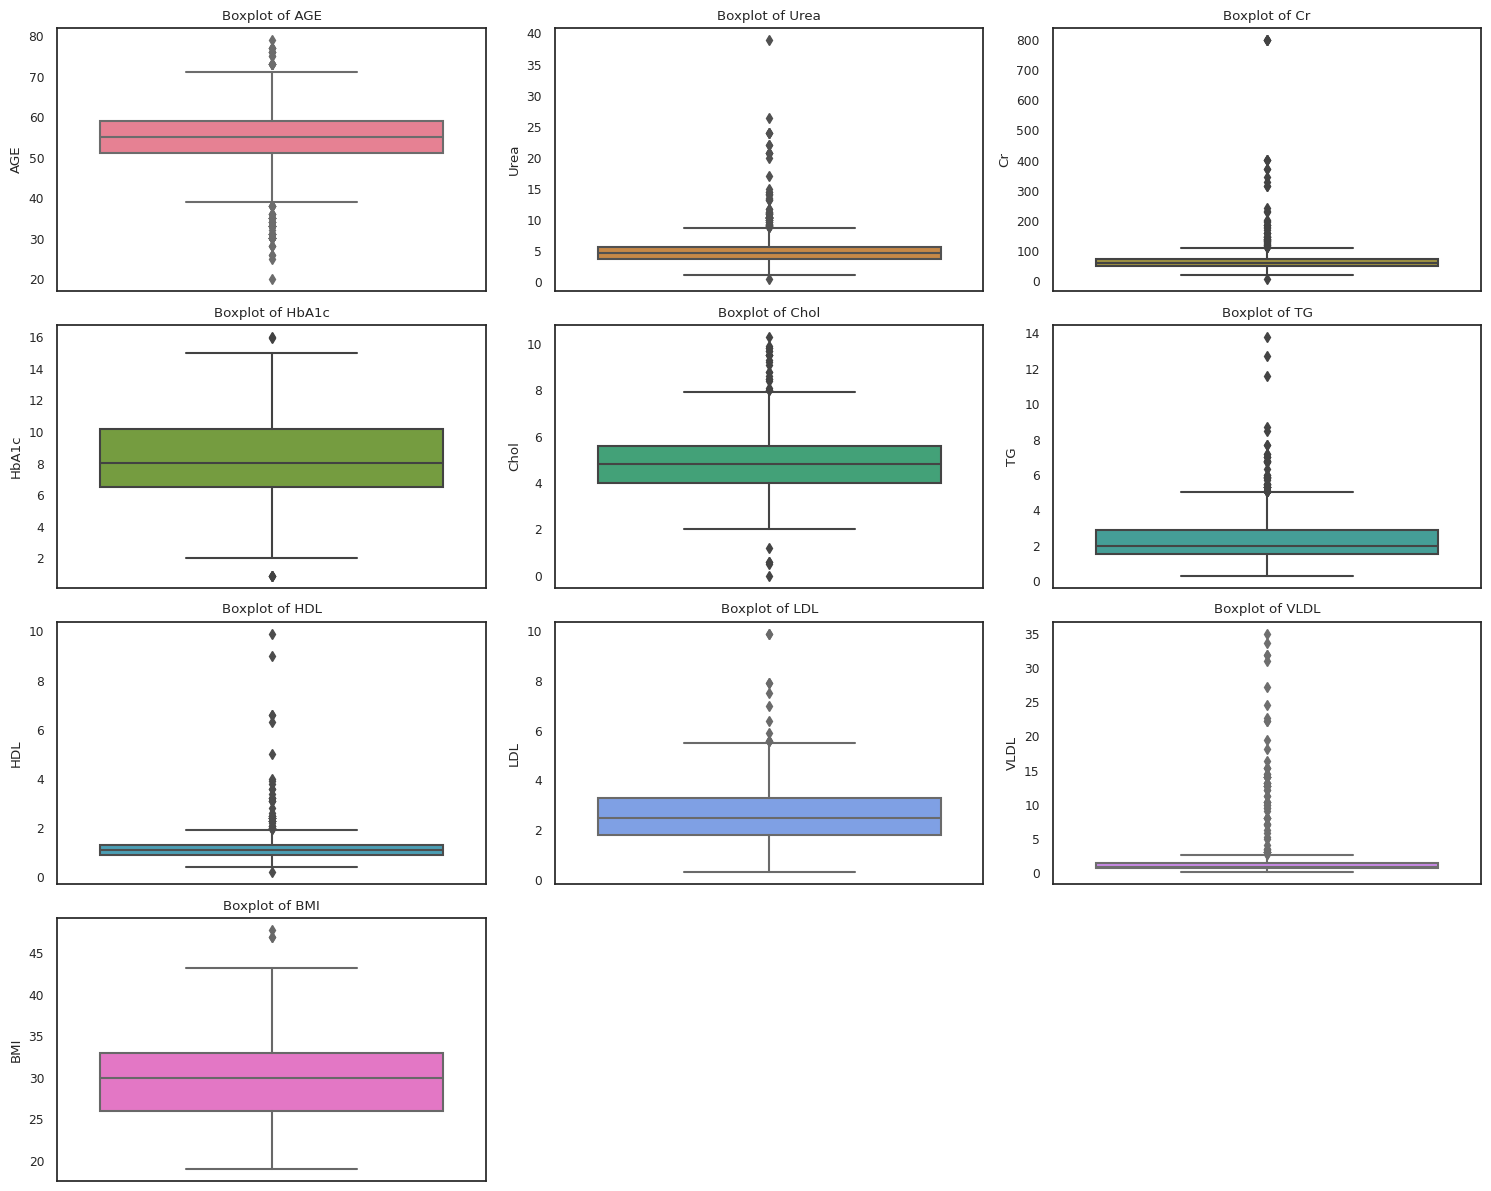

In [51]:

# List of columns to create boxplots for
numerical_cols = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']

# Define a custom color palette for the boxplots
colors = sns.color_palette("husl", len(numerical_cols))  

# Set up the plot grid
plt.figure(figsize=(15, 12))  
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)  # Create subplots in a 4x3 grid
    sns.boxplot(y=col, data=data, color=colors[i-1])  # Assign a unique color to each boxplot
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()  # Adjusts spacing to fit plots

plt.show()


#### Observation

There are many outliers in the dataset.

#### Why Removing Outliers is Necessary?

Impact on Analysis: Outliers will have a disproportionate influence on statistical measures like the suggest, skewing the general outcomes and leading to misguided conclusions. Removing outliers can help ensure the analysis is based totally on a more representative sample of the information.

Statistical Significance: Outliers can have an effect on the validity and reliability of statistical inferences drawn from the facts. Removing outliers, when appropriate, can assist maintain the statistical importance of the analysis.
https://www.geeksforgeeks.org/what-are-outliers-in-data/

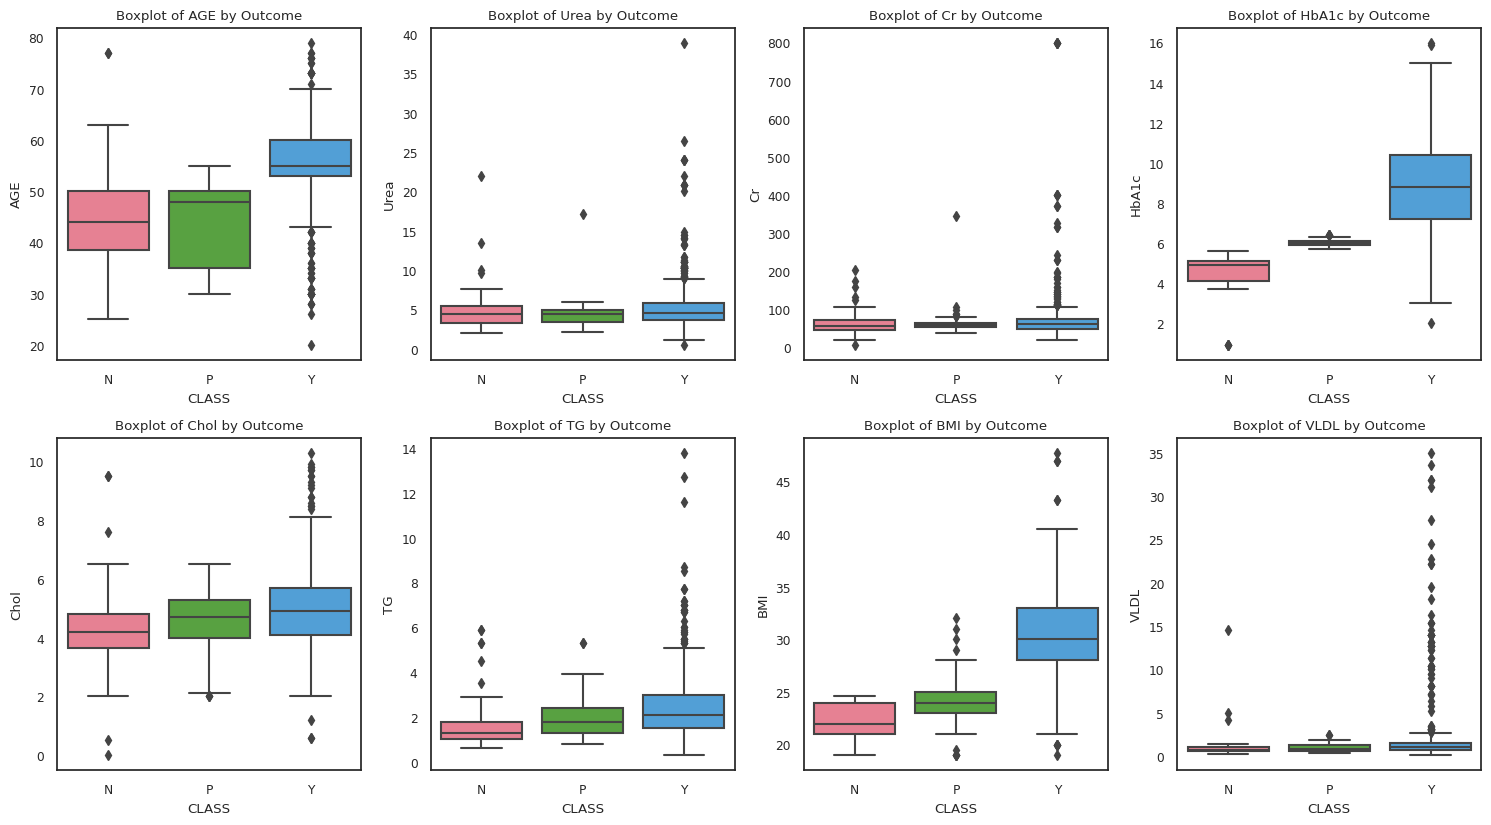

In [52]:


# Columns to plot (numerical features)
numerical_cols = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'BMI', 'VLDL']

# Define a list of colors to use for the box plots
colors = sns.color_palette("husl", 3)  # Use 3 distinct colors for the three classes

# Set up the plot grid
plt.figure(figsize=(15, 12))  
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)  
    sns.boxplot(x='CLASS', y=col, data=data, palette=colors)  # Plot boxplot with classes differentiated by color
    plt.title(f'Boxplot of {col} by Outcome')
    plt.tight_layout()  

plt.show()


#### Observation

It can be seen that there are more outliers in the diabetic class (2)

## **Feature Importance**

In [53]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()


# Encode 'Gender' column: 'M' becomes 0 and 'F' becomes 1
data['Gender'] = label_encoder.fit_transform(data['Gender'])

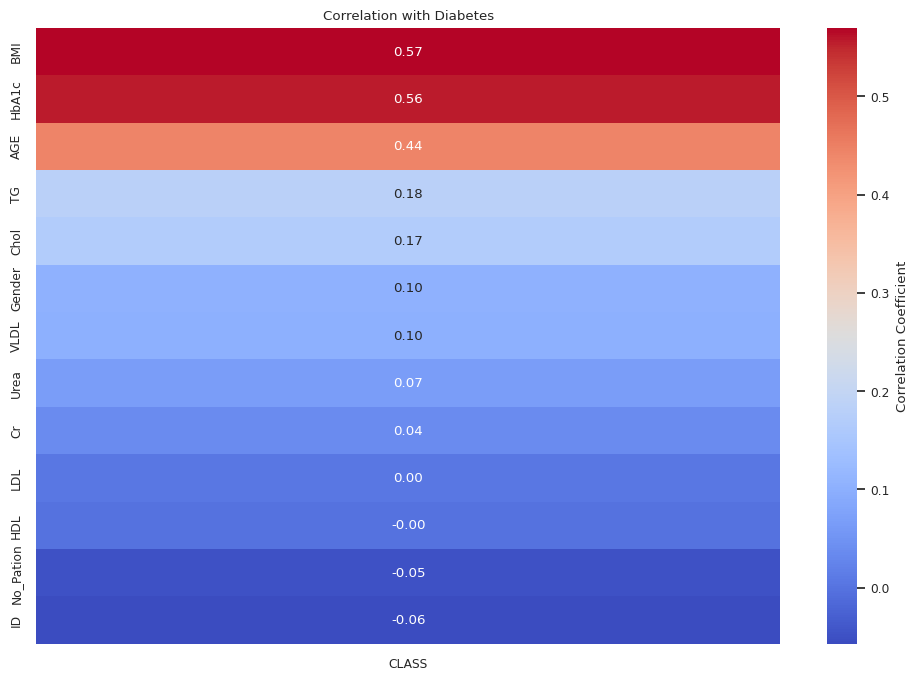

In [54]:

# Select numeric columns only and map the 'CLASS' column to numerical values
dataCorr = data.select_dtypes(include=[np.number])  
dataCorr['CLASS'] = data['CLASS'].map({'N': 0, 'P': 1, 'Y': 2})

# Check if the mapping resulted in any NaN values in 'CLASS'
if dataCorr['CLASS'].isnull().any():
    print("NaN values found in 'CLASS' after mapping. Check the mapping values.")
else:
    # Calculate correlation on the updated DataFrame
    corr = dataCorr.corr()

    # Get correlations with the target column 'CLASS'
    target_corr = corr['CLASS'].drop('CLASS')

    # Sort correlation values in descending order
    target_corr_sorted = target_corr.sort_values(ascending=False)

    # Set the style for the heatmap
    sns.set(font_scale=0.8)
    sns.set_style("white")
    plt.figure(figsize=(12, 8)) 
    sns.set_palette("PuBuGn_d")

    # Create a heatmap for the sorted correlation values
    sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={"label": "Correlation Coefficient"})

    # Set title and show the plot
    plt.title('Correlation with Diabetes')
    plt.show()


**Observation for correlation matrix**

Note that the classes ID, No_Pation, HDL, LDL have negligible influence to negative influence on the class variable indication.

# 4. Preprocessing

#### Feature Selection

Left out features: ID, No_Pation, HDL, and LDL were excluded from the analysis due to their negligible or negative impact on the class variable.

In [55]:
data=data.drop(columns=['ID', 'No_Pation', 'HDL', 'LDL']) # feature selection

In [56]:
data.head(3)

Gender  AGE  Urea  Cr  HbA1c  Chol   TG  VLDL   BMI CLASS
0       0   50   4.7  46    4.9   4.2  0.9   0.5  24.0     N
1       1   26   4.5  62    4.9   3.7  1.4   0.6  23.0     N
2       0   50   4.7  46    4.9   4.2  0.9   0.5  24.0     N

In [57]:
def remove_outliers_z_score(df, threshold=3):

    # Select only numerical columns
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Calculate Z-scores for the numerical columns
    z_scores = np.abs(stats.zscore(df_numeric))
    
    # Keep rows where all Z-scores are below the threshold
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    
    return df_no_outliers

# Apply the function to the dataset
data = remove_outliers_z_score(data)


In [58]:
# Split the data into features (X) and target variable (y)
X = data.drop('CLASS', axis=1)  # Features
y = data['CLASS']  # Target variable

# 5. Building models

## 5.1.Single models

In [59]:
warnings.simplefilter(action='ignore', category=FutureWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models with possible hyperparameters
models = {
    'Logistic Regression': LogisticRegression(multi_class='ovr', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42, decision_function_shape='ovr')
}

# Initialize results storage
results = {}

# Create pipelines with scaling and SMOTE
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Define parameter grid for hyperparameter tuning
    if name == 'Random Forest':
        param_grid = {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20]
        }

    else:
        param_grid = {}
    
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='roc_auc_ovr')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline
        best_model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)  # Probabilities for all classes

    # Handle multiclass ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    
    # Calculate accuracies
    train_acc = best_model.score(X_train, y_train)  # Training accuracy
    test_acc = best_model.score(X_test, y_test)    # Testing accuracy

    # Store results
    results[name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'ROC AUC Score': roc_auc,
        'Classification Report': classification_report(y_test, y_pred)
    }

# Print metric results
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Training Accuracy: {metrics['Train Accuracy']:.2f}")
    print(f"Testing Accuracy: {metrics['Test Accuracy']:.2f}")
    print(f"ROC AUC Score: {metrics['ROC AUC Score']:.2f}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    print('=' * 50)


Model: Logistic Regression
Training Accuracy: 0.92
Testing Accuracy: 0.91
ROC AUC Score: 0.94
Classification Report:
              precision    recall  f1-score   support

           N       0.70      0.84      0.76        19
           P       0.42      0.50      0.45        10
           Y       0.98      0.94      0.96       153

    accuracy                           0.91       182
   macro avg       0.70      0.76      0.73       182
weighted avg       0.92      0.91      0.91       182

Model: Random Forest
Training Accuracy: 1.00
Testing Accuracy: 0.99
ROC AUC Score: 1.00
Classification Report:
              precision    recall  f1-score   support

           N       0.95      1.00      0.97        19
           P       1.00      0.90      0.95        10
           Y       0.99      0.99      0.99       153

    accuracy                           0.99       182
   macro avg       0.98      0.96      0.97       182
weighted avg       0.99      0.99      0.99       182

Model: Gra

#### Observation for single models


The Logistic Regression and SVM are performing well w.r.t. the AUC-ROC score but when looking closer into the metrics we notice that it is not performing efficiently.

Random forest and SVM are performing exceptionally well.

## **Ensemble models**

Why Ensemble Models Are Better Than Single Models?????:

1. **Reduced Overfitting**:
Ensemble models reduce overfitting by averaging the predictions of multiple models, lowering variance and generalizing better.

2. **Improved Accuracy**:
Combining multiple models increases predictive accuracy, as ensemble methods correct errors made by individual models.

3. **Diverse Perspectives**:
Different models capture different patterns in the data, and ensemble methods aggregate these perspectives for more comprehensive predictions.

4. **Reduced Bias**:
Boosting techniques iteratively reduce bias by refining the predictions based on previous errors, improving model performance.




## **5.2.Ensemble model using smote**

In [60]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define individual models
log_reg = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svc = SVC(probability=True, random_state=42, decision_function_shape='ovr')

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf),
        ('svc', svc),
        ('gb', gb)
    ],
    voting='soft'
)

# Create a pipeline with scaling, SMOTE, and the voting classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),      # Handling class imbalance
    ('voting_clf', voting_clf)              # Ensemble classifier
])

# Define Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define Grid Search for the logistic regression component
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={
        'voting_clf__log_reg__C': [0.1, 1, 10, 100],
        'voting_clf__log_reg__penalty': ['l2']  # regulation method that prevents overfitting
                                                #makes the model simpler by shrinking the weights of the features, but it doesn’t make them exactly zero.
    },
    cv=cv,
    scoring='roc_auc_ovr',  # Use 'roc_auc_ovr' for multiclass
    n_jobs=-1
)

# Train the model with Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)  # Probabilities for all classes

# For multiclass ROC AUC
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')



####  **5.2.1) Evaluating the models performance**

In [61]:
# Print the classification report and ROC AUC score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:3f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Training Accuracy: {best_model.score(X_train, y_train):.3f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred):.3f}")


Best Parameters: {'voting_clf__log_reg__C': 0.1, 'voting_clf__log_reg__penalty': 'l2'}
ROC AUC Score (One-vs-Rest): 0.997279
Classification Report:
              precision    recall  f1-score   support

           N       1.00      1.00      1.00        19
           P       1.00      0.80      0.89        10
           Y       0.99      1.00      0.99       153

    accuracy                           0.99       182
   macro avg       1.00      0.93      0.96       182
weighted avg       0.99      0.99      0.99       182

Training Accuracy: 0.996
Testing Accuracy: 0.989


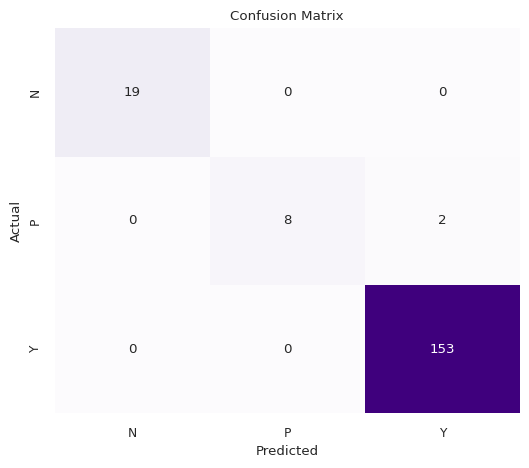

In [62]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**OBSERVATION FOR BEST CLASSIFYING MODEL**

Note that there are only 2 misclassifications. With regards to Pre-Diabetic

The training and testing accuracies are close in range indicating that the model is learning the patterns well on the training dataset and is effectively able to identify them with in the testing dataset.

For class N (non-diabetic), both precision and recall are 1.00, meaning there are no false positives or false negatives for this class.

For class P (pre-diabetic), precision is 1.00, but recall is 0.80, indicating some true positives (actual pre-diabetic cases) are missed.

For class Y (diabetic), precision is 0.99, and recall is 1.00, meaning nearly all predictions for diabetic patients are correct, with no missed cases.

# 6. Explainable AI----LIME

## Interpreting index 71: 

In [63]:

# Suppress specific UserWarnings related to feature names
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

# Initialize the LIME explainer
feature_names = X.columns.tolist()  
class_names = ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'] 

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

instance_index = 71 
instance_to_explain = X_test.values[instance_index]

# Get the predicted class and probabilities for the instance
predicted_class_label = best_model.predict(instance_to_explain.reshape(1, -1))[0]  # This is a string
predicted_proba = best_model.predict_proba(instance_to_explain.reshape(1, -1))

# Get the actual class from the test set
actual_class = y_test.values[instance_index]  

# Map actual class to index
actual_class_index = {'N': 0, 'P': 1, 'Y': 2}[actual_class]  

# Map predicted class label to index
predicted_class_index = {'N': 0, 'P': 1, 'Y': 2}[predicted_class_label]  # Mapping predicted class to index

# Generate explanation for the selected instance
exp = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_model.predict_proba,  # function that returns probabilities
    num_features=9  # number of features to display
)

# Visualize the explanation
exp.show_in_notebook(show_table=True)

# Print actual and predicted values
print(f"Actual Class: {class_names[actual_class_index]}")
print(f"Predicted Class: {class_names[predicted_class_index]}")  # Use the mapped index
print(f"Predicted Probabilities: {predicted_proba}")


Actual Class: Diabetic
Predicted Class: Diabetic
Predicted Probabilities: [[1.08032143e-04 2.18332436e-02 9.78058724e-01]]


## Interpreting Index 4:

In [64]:


# Suppress specific UserWarnings related to feature names
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

# Initialize the LIME explainer
feature_names = X.columns.tolist()  
class_names = ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'] 

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)


instance_index = 4 
instance_to_explain = X_test.values[instance_index]

# Get the predicted class and probabilities for the instance
predicted_class_label = best_model.predict(instance_to_explain.reshape(1, -1))[0] 
predicted_proba = best_model.predict_proba(instance_to_explain.reshape(1, -1))

# Get the actual class from the test set
actual_class = y_test.values[instance_index] 

# Map actual class to index
actual_class_index = {'N': 0, 'P': 1, 'Y': 2}[actual_class] 

# Map predicted class label to index
predicted_class_index = {'N': 0, 'P': 1, 'Y': 2}[predicted_class_label]  # Mapping predicted class to index

# Generate explanation for the selected instance
exp = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_model.predict_proba,  # This must be a function that returns probabilities
    num_features=9  # Adjust the number of features to display
)

# Visualize the explanation
exp.show_in_notebook(show_table=True)

# Print actual and predicted values
print(f"Actual Class: {class_names[actual_class_index]}")
print(f"Predicted Class: {class_names[predicted_class_index]}")  # Use the mapped index
print(f"Predicted Probabilities: {predicted_proba}")


Actual Class: Non-Diabetic
Predicted Class: Non-Diabetic
Predicted Probabilities: [[0.93654605 0.0383508  0.02510315]]


## Interpreting index 8

In [65]:


# Suppress specific UserWarnings related to feature names
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

# Initialize the LIME explainer
feature_names = X.columns.tolist()  # Assuming X is a DataFrame
class_names = ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'] 

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)


instance_index = 8  #explaining index 8
instance_to_explain = X_test.values[instance_index]

# Get the predicted class and probabilities for the instance
predicted_class_label = best_model.predict(instance_to_explain.reshape(1, -1))[0]  # This is a string
predicted_proba = best_model.predict_proba(instance_to_explain.reshape(1, -1))

# Get the actual class from the test set
actual_class = y_test.values[instance_index]  

# Map actual class to index
actual_class_index = {'N': 0, 'P': 1, 'Y': 2}[actual_class]  

# Map predicted class label to index
predicted_class_index = {'N': 0, 'P': 1, 'Y': 2}[predicted_class_label]  # Mapping predicted class to index

# Generate explanation for the selected instance
exp = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_model.predict_proba,  # This must be a function that returns probabilities
    num_features=9  

# Visualize the explanation
exp.show_in_notebook(show_table=True)

# Print actual and predicted values
print(f"Actual Class: {class_names[actual_class_index]}")
print(f"Predicted Class: {class_names[predicted_class_index]}")  # Use the mapped index
print(f"Predicted Probabilities: {predicted_proba}")


Actual Class: Pre-Diabetic
Predicted Class: Pre-Diabetic
Predicted Probabilities: [[0.02520281 0.93022334 0.04457385]]


  feature  shap_importance
4   HbA1c         0.084063
8     BMI         0.064831
1     AGE         0.041820
5    Chol         0.021351
7    VLDL         0.009423
6      TG         0.009373
3      Cr         0.002936
2    Urea         0.002203
0  Gender         0.002132


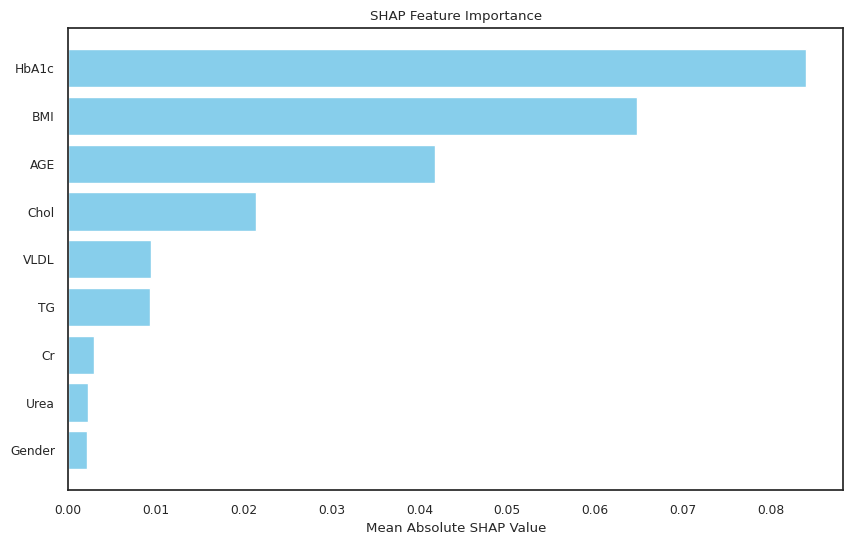

In [67]:

# Load data
X_shap = data.drop(columns=['CLASS'])  
y_shap = data['CLASS'] 

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_shap, y_shap, test_size=0.2, random_state=42)

# Train the model (Random Forest in this case)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)


# For multiclass, average across all classes
shap_importance = np.mean([np.abs(shap_val).mean(0) for shap_val in shap_values], axis=0)

# Create a DataFrame for feature importance ranking
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': shap_importance
})

# Sort the features by SHAP importance
importance_df = importance_df.sort_values(by='shap_importance', ascending=False)
print(importance_df)

# Plot feature importance as a bar chart
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['shap_importance'], color="skyblue")
plt.xlabel('Mean Absolute SHAP Value')
plt.title('SHAP Feature Importance')
plt.gca().invert_yaxis()
plt.show()
